In [ ]:
####  If not GD, run from local starts here ##############

In [21]:
project_path="/FINDER_CM"

In [22]:
# magic line for local jupyter notebooks
%matplotlib inline

In [23]:
import time
import sys,os

import networkx as nx
import numpy as np
import random
import os
import os
from shutil import copyfile
from tqdm import tqdm


# use old module functions
sys.path.append(f'{project_path}/FINDER-pytorch/code/FINDER_ND_CM/')
from FINDER import FINDER

old_finder = FINDER()

# HXA with maxcc
def HXA(g, method):
        # 'HDA', 'HBA', 'HPRA', 'HCA'
        sol = []
        G = g.copy()
        while (nx.number_of_edges(G)>0):
            if method == 'HDA':
                dc = nx.degree_centrality(G)
            elif method == 'HBA':
                dc = nx.betweenness_centrality(G)
            elif method == 'HCA':
                dc = nx.closeness_centrality(G)
            elif method == 'HPRA':
                dc = nx.pagerank(G)
            keys = list(dc.keys())
            values = list(dc.values())
            maxTag = np.argmax(values)
            node = keys[maxTag]
            sol.append(node)
            G.remove_node(node)
        solution = sol + list(set(g.nodes())^set(sol))
        solutions = [int(i) for i in solution]
        Robustness = old_finder.utils.getRobustness(old_finder.GenNetwork(g), solutions)
        MaxCCList = old_finder.utils.MaxWccSzList
        return Robustness,MaxCCList,solutions

# modified from original EvaluateSol
def EvaluateSol(g, sol_file, strategyID=0, reInsertStep=20):
        #evaluate the robust given the solution, strategyID:0,count;2:rank;3:multipy
        #sys.stdout.flush()
        # g = nx.read_weighted_edgelist(data_test)
        #g = nx.read_gml(data_test)
        g_inner = old_finder.GenNetwork(g)
        print('Evaluating FINDER model')
        print('number of nodes:%d'%nx.number_of_nodes(g))
        print('number of edges:%d'%nx.number_of_edges(g))
        nodes = list(range(nx.number_of_nodes(g)))
        sol = []
        for line in open(sol_file):
            sol.append(int(line))

        sol_left = list(set(nodes)^set(sol))
        if strategyID > 0:
            start = time.time()
            sol_reinsert = old_finder.utils.reInsert(g_inner, sol, sol_left, strategyID, reInsertStep)
            end = time.time()
            print ('reInsert time:%.6f'%(end-start))
        else:
            sol_reinsert = sol
        solution = sol_reinsert + sol_left
        print('number of solution nodes:%d'%len(solution))
        Robustness = old_finder.utils.getRobustness(g_inner, solution)
        MaxCCList = old_finder.utils.MaxWccSzList
        return Robustness, MaxCCList, solution


# load graph from ready to use gml (converted from datasets)
# Network names are: "Digg", "HI-II-14"
# Weight types are: 001, degree, random, zero
def build_graph_path(network_name,weight_type="001"):
    return f"{project_path}/FINDER-pytorch/data/real/cost/{network_name}_{weight_type}.gml"

# load solution files generated by model
# Network names are: "Digg", "HI-II-14"
# Model names are: FINDER_ND_cost, old_FINDER_ND_cost_tf etc.
# step_ratio are: 0.0100, etc.
# Weight types are: 001, degree, random, zero
def build_solution_path(network_name,model_name="FINDER_CN_cost",step_ratio="0.0100",weight_type="001"):
    data_folder=""
    if(weight_type!=""):
        weight_type=f"_{weight_type}"
        data_folder=f"Data{weight_type}/"
    return f"{project_path}/FINDER-pytorch/code/results/{model_name}/real/{data_folder}StepRatio_{step_ratio}/{network_name}{weight_type}.txt"



In [24]:
def get_node_weights(g):
    sum=0.0
    for i,v in g.nodes(data=True):
        sum+=v["weight"]
    return sum

# compute the ratio of cost of removed nodes / totol cost
# TODO, add step (or not, since it's test dataset, step is just trick at training stage)
def get_frac_cost_of_removed_nodes(g,solutions,ND_cost=False,verbose=0):
    num_nodes = nx.number_of_nodes(g) 
    if(ND_cost):
      total_weight = get_node_weights(g)
    else:
      total_weight = g.size()

    g_mod = g.copy()
    if(verbose>0):
        print("\nOriginal # of nodes: ",num_nodes)
        print("Original total weight: ",total_weight)
        print("Solution: ", len(solutions), " = ", solutions , "\n")

    frac_cost_list=[]
    for rm_node in tqdm(solutions):
    #for rm_node in reversed(solutions):
        g_mod.remove_node(rm_node)
        if(ND_cost):
          left_weight = get_node_weights(g_mod)
        else:
          left_weight = g_mod.size()

        frac_cost = (total_weight - left_weight) / total_weight
        frac_cost_list.append(frac_cost)
        if(verbose>1):
            print("Removed node: ", rm_node)
            print("left_weight: ", left_weight)
            print("Frac cost of removed nodes: ", frac_cost)
                
    return frac_cost_list



  2%|█▏                                                                              | 64/4165 [00:00<00:06, 632.07it/s]

Evaluating FINDER model
number of nodes:4165
number of edges:13087
number of solution nodes:4165


  1%|█▏                                                                              | 59/4165 [00:00<00:06, 587.98it/s]

Evaluating FINDER model
number of nodes:4165
number of edges:13087
number of solution nodes:4165


  1%|█                                                                               | 57/4165 [00:00<00:07, 568.88it/s]

Evaluating FINDER model
number of nodes:4165
number of edges:13087
number of solution nodes:4165


  1%|█▏                                                                              | 61/4165 [00:00<00:06, 603.38it/s]

Evaluating FINDER model
number of nodes:4165
number of edges:13087
number of solution nodes:4165


100%|█████████████████████████████████████████████████████████████████████████████| 4165/4165 [00:03<00:00, 1146.98it/s]


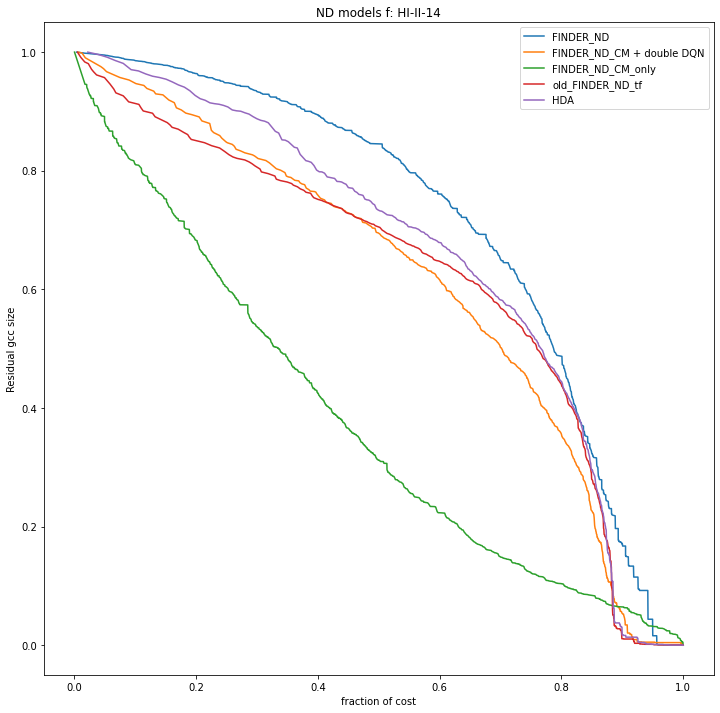

In [33]:

# plot
from matplotlib import pyplot as plt

cost_model_settings = ['FINDER_ND_cost','FINDER_ND_cost_CM','FINDER_ND_cost_CM_only','old_FINDER_ND_cost_tf','HDA']
model_settings = ['FINDER_ND','FINDER_ND_CM','FINDER_ND_CM_only','old_FINDER_ND_tf','HDA']

datasets = ["HI-II-14","Yang-16","Yu-11","Venkatesan-09","H-I-05"]

def load_from_file(f):
    FINDER_f = open(f, "r")

    scores = []
    for score in FINDER_f:
        scores.append(float(score))

    return scores

def plot_graphs(dataset_name, model_settings):
    # load network
    g = nx.read_edgelist(f"{project_path}/FINDER-pytorch/data/real/{dataset_name}.txt", nodetype=int)
       
    plt.figure(figsize=(12,12))
    
    # load maxcclist directly from scorefiles
    for model_name in model_settings:
        if(model_name=="HDA"):
            # get HDA solution
            HDA_robustness, HDA_maxcclist,HDA_solutions  = HXA(g, "HDA")
            #print("From HDA:",HDA_robustness, HDA_maxcclist[0:5],HDA_solutions[0:5])
            HDA_frac_cost_list = get_frac_cost_of_removed_nodes(g,HDA_solutions)
            plt.plot(HDA_frac_cost_list, HDA_maxcclist, label=model_name)
        else:
            labelname = model_name
            if(model_name=="FINDER_ND_CM"):
                labelname="FINDER_ND_CM + double DQN"
            FINDER_robustness, FINDER_maxcclist,FINDER_solutions = EvaluateSol(g, f"{project_path}/FINDER-pytorch/code/results/{model_name}/real/StepRatio_0.0100/{dataset_name}.txt")
            FINDER_frac_cost_list = get_frac_cost_of_removed_nodes(g,FINDER_solutions)
            FINDER_maxcclist2=load_from_file(f"{project_path}/FINDER-pytorch/code/results/{model_name}/real/StepRatio_0.0100/MaxCCList_Strategy_{dataset_name}.txt")
            plt.plot(FINDER_frac_cost_list, FINDER_maxcclist2, label=labelname)
            #plt.plot(FINDER_frac_cost_list, FINDER_maxcclist2, label=f"{model_name} from file")

    plt.legend()
    plt.xlabel("fraction of cost")
    plt.ylabel("Residual gcc size")
    plt.title(f"ND models f: {dataset_name}")
    plt.show()

plot_graphs("HI-II-14",model_settings)

100%|███████████████████████████████████████████████████████████████████████████████| 502/502 [00:00<00:00, 9624.32it/s]

Evaluating FINDER model
number of nodes:502
number of edges:717
number of solution nodes:502
Evaluating FINDER model
number of nodes:502
number of edges:717
number of solution nodes:502
Evaluating FINDER model
number of nodes:502
number of edges:717
number of solution nodes:502
Evaluating FINDER model
number of nodes:502
number of edges:717



100%|███████████████████████████████████████████████████████████████████████████████| 502/502 [00:00<00:00, 9901.11it/s]


number of solution nodes:502


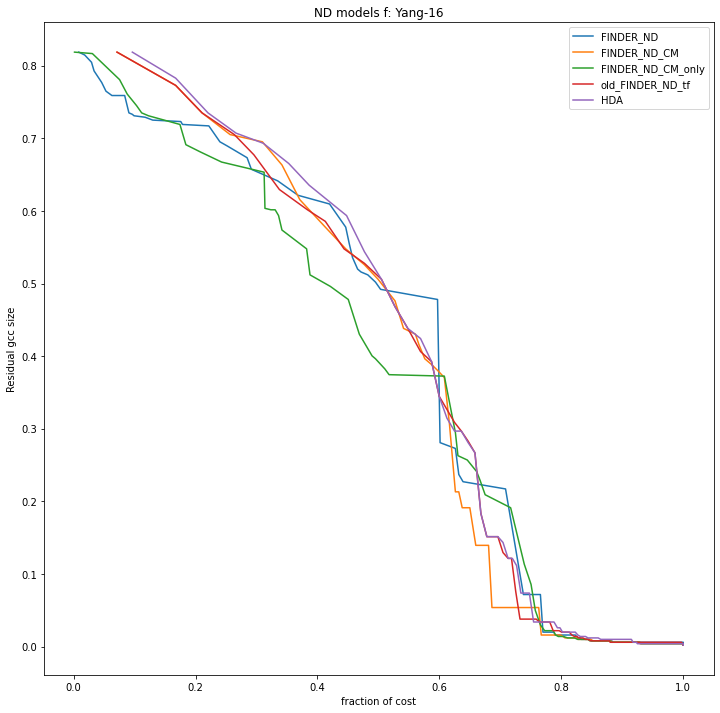

In [26]:
plot_graphs("Yang-16",model_settings)

  1%|█▏                                                                              | 62/4165 [00:00<00:06, 615.17it/s]

Evaluating FINDER model
number of nodes:4165
number of edges:13087
number of solution nodes:4165


  1%|█                                                                               | 58/4165 [00:00<00:07, 578.55it/s]

Evaluating FINDER model
number of nodes:4165
number of edges:13087
number of solution nodes:4165


  2%|█▏                                                                              | 63/4165 [00:00<00:06, 620.75it/s]

Evaluating FINDER model
number of nodes:4165
number of edges:13087
number of solution nodes:4165


  2%|█▏                                                                              | 63/4165 [00:00<00:06, 622.79it/s]

Evaluating FINDER model
number of nodes:4165
number of edges:13087
number of solution nodes:4165


100%|█████████████████████████████████████████████████████████████████████████████| 4165/4165 [00:03<00:00, 1254.22it/s]


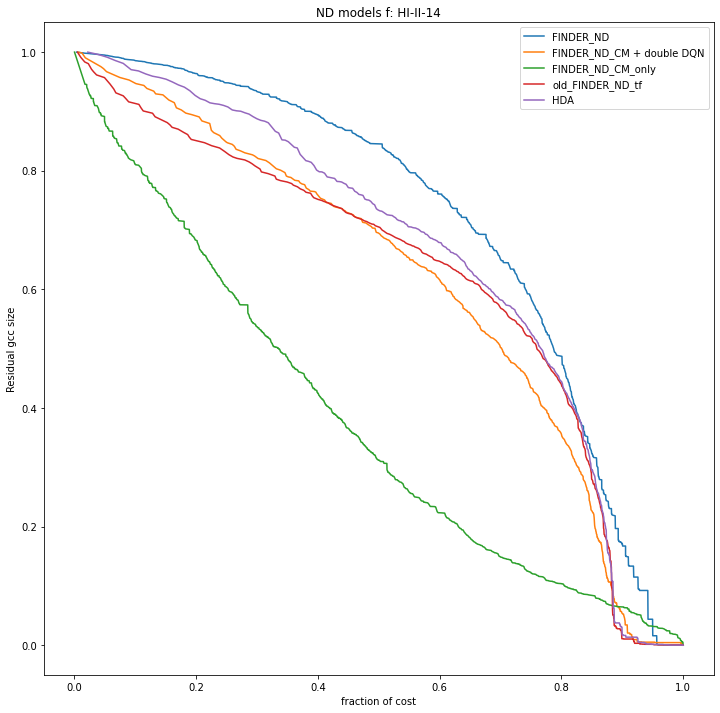

100%|███████████████████████████████████████████████████████████████████████████████| 502/502 [00:00<00:00, 9663.10it/s]

Evaluating FINDER model
number of nodes:502
number of edges:717
number of solution nodes:502
Evaluating FINDER model
number of nodes:502
number of edges:717
number of solution nodes:502
Evaluating FINDER model
number of nodes:502
number of edges:717
number of solution nodes:502
Evaluating FINDER model
number of nodes:502
number of edges:717
number of solution nodes:502



100%|███████████████████████████████████████████████████████████████████████████████| 502/502 [00:00<00:00, 9501.07it/s]


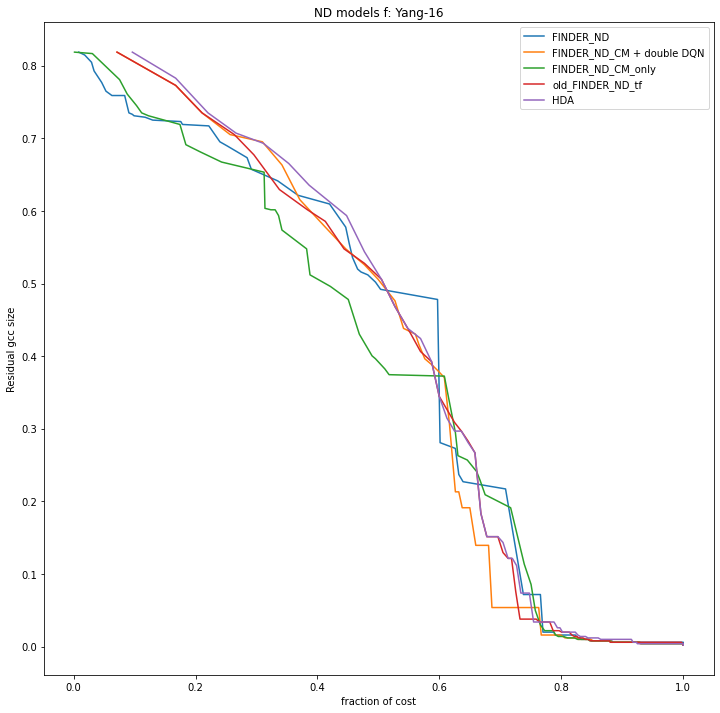

 22%|████████████████▉                                                             | 245/1132 [00:00<00:00, 2446.76it/s]

Evaluating FINDER model
number of nodes:1132
number of edges:1126
number of solution nodes:1132


 23%|█████████████████▉                                                            | 260/1132 [00:00<00:00, 2597.06it/s]

Evaluating FINDER model
number of nodes:1132
number of edges:1126
number of solution nodes:1132


 23%|██████████████████▏                                                           | 264/1132 [00:00<00:00, 2632.87it/s]

Evaluating FINDER model
number of nodes:1132
number of edges:1126
number of solution nodes:1132


 23%|██████████████████                                                            | 262/1132 [00:00<00:00, 2612.19it/s]

Evaluating FINDER model
number of nodes:1132
number of edges:1126
number of solution nodes:1132


100%|█████████████████████████████████████████████████████████████████████████████| 1132/1132 [00:00<00:00, 4530.48it/s]


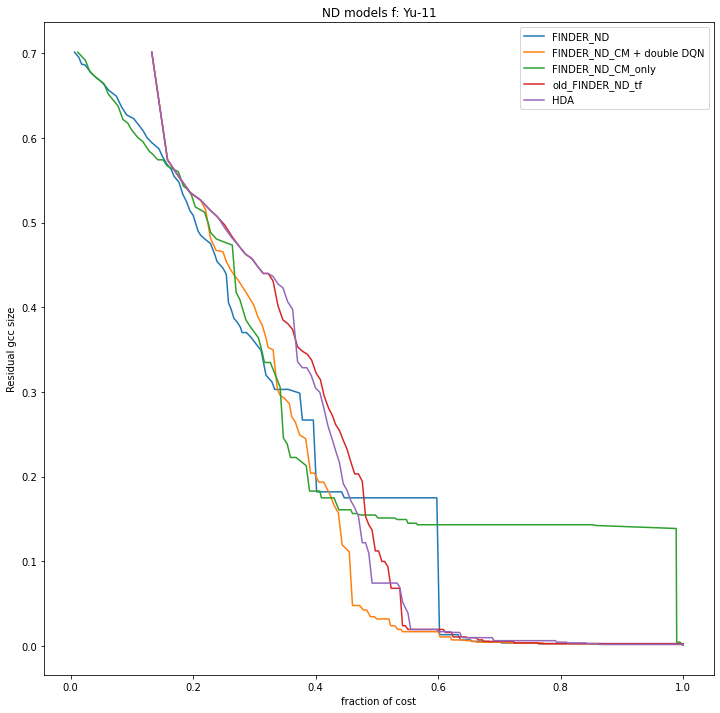

100%|██████████████████████████████████████████████████████████████████████████████| 195/195 [00:00<00:00, 23349.59it/s]

Evaluating FINDER model
number of nodes:195
number of edges:187
number of solution nodes:195
Evaluating FINDER model
number of nodes:195
number of edges:187
number of solution nodes:195
Evaluating FINDER model
number of nodes:195
number of edges:187
number of solution nodes:195
Evaluating FINDER model
number of nodes:195
number of edges:187
number of solution nodes:195


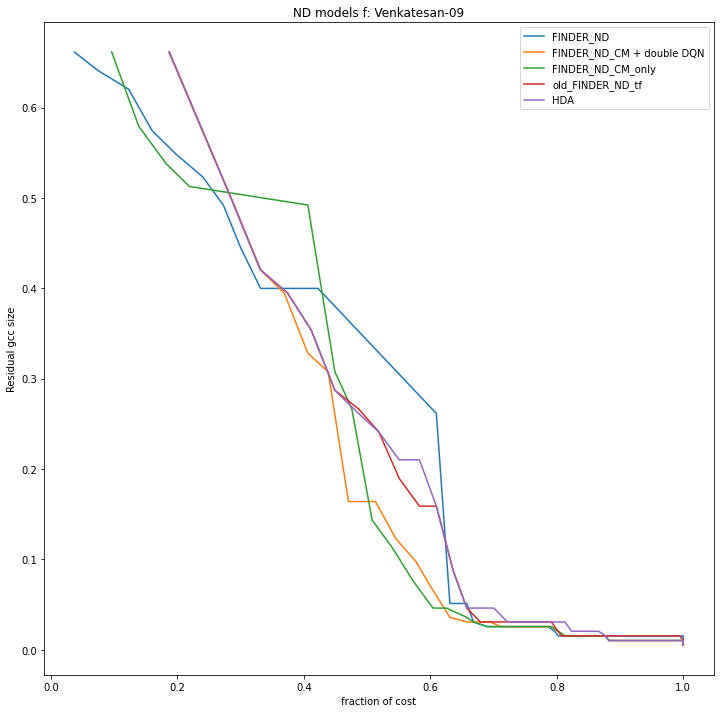

 12%|█████████▋                                                                    | 186/1504 [00:00<00:00, 1853.57it/s]

Evaluating FINDER model
number of nodes:1504
number of edges:2565
number of solution nodes:1504


 12%|█████████▏                                                                    | 178/1504 [00:00<00:00, 1771.10it/s]

Evaluating FINDER model
number of nodes:1504
number of edges:2565
number of solution nodes:1504


 12%|█████████▍                                                                    | 182/1504 [00:00<00:00, 1814.81it/s]

Evaluating FINDER model
number of nodes:1504
number of edges:2565
number of solution nodes:1504


 12%|█████████▍                                                                    | 182/1504 [00:00<00:00, 1813.73it/s]

Evaluating FINDER model
number of nodes:1504
number of edges:2565
number of solution nodes:1504


100%|█████████████████████████████████████████████████████████████████████████████| 1504/1504 [00:00<00:00, 3360.39it/s]


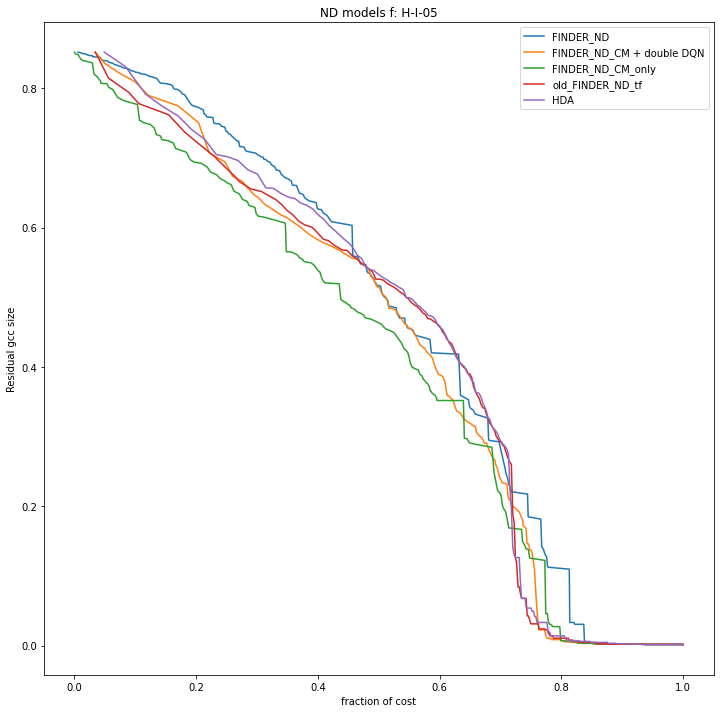

In [35]:
for dataset in datasets:
    plot_graphs(dataset,model_settings)

  1%|█▏                                                                              | 59/4165 [00:00<00:07, 580.03it/s]

Evaluating FINDER model
number of nodes:4165
number of edges:13087
number of solution nodes:4165


  1%|█                                                                               | 53/4165 [00:00<00:07, 525.52it/s]

Evaluating FINDER model
number of nodes:4165
number of edges:13087
number of solution nodes:4165


  1%|█                                                                               | 53/4165 [00:00<00:07, 527.98it/s]

Evaluating FINDER model
number of nodes:4165
number of edges:13087
number of solution nodes:4165


  1%|█▏                                                                              | 62/4165 [00:00<00:06, 614.84it/s]

Evaluating FINDER model
number of nodes:4165
number of edges:13087
number of solution nodes:4165


100%|█████████████████████████████████████████████████████████████████████████████| 4165/4165 [00:03<00:00, 1225.85it/s]


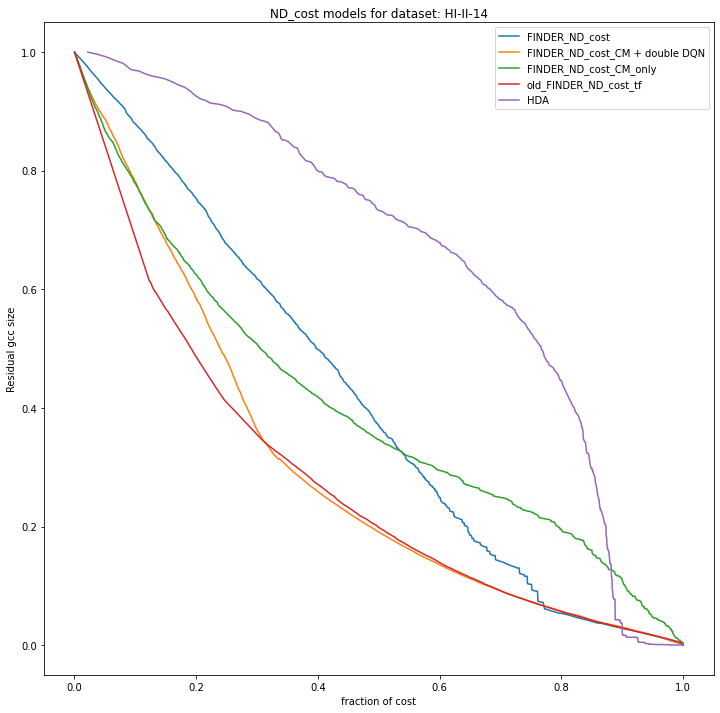

In [34]:
def plot_cost_graphs(dataset_name, model_settings):
    # load network
    g = nx.read_gml(f"{project_path}/FINDER-pytorch/data/real/cost/{dataset_name}_degree.gml",destringizer=int)
       
    plt.figure(figsize=(12,12))
    
    # load maxcclist directly from scorefiles
    for model_name in model_settings:
        if(model_name=="HDA"):
            # get HDA solution
            HDA_robustness, HDA_maxcclist,HDA_solutions  = HXA(g, "HDA")
            #print("From HDA:",HDA_robustness, HDA_maxcclist[0:5],HDA_solutions[0:5])
            HDA_frac_cost_list = get_frac_cost_of_removed_nodes(g,HDA_solutions)
            plt.plot(HDA_frac_cost_list, HDA_maxcclist, label=model_name)
        else:
            labelname = model_name
            if(model_name=="FINDER_ND_cost_CM"):
                labelname="FINDER_ND_cost_CM + double DQN"
            FINDER_robustness, FINDER_maxcclist,FINDER_solutions = EvaluateSol(g, f"{project_path}/FINDER-pytorch/code/results/{model_name}/real/Data_degree/StepRatio_0.0100/{dataset_name}_degree.txt")
            FINDER_frac_cost_list = get_frac_cost_of_removed_nodes(g,FINDER_solutions)
            FINDER_maxcclist2=load_from_file(f"{project_path}/FINDER-pytorch/code/results/{model_name}/real/Data_degree/StepRatio_0.0100/MaxCCList__Strategy_{dataset_name}.txt")
            plt.plot(FINDER_frac_cost_list, FINDER_maxcclist2, label=labelname)
            #plt.plot(FINDER_frac_cost_list, FINDER_maxcclist2, label=f"{model_name} from file")

    plt.legend()
    plt.xlabel("fraction of cost")
    plt.ylabel("Residual gcc size")
    plt.title(f"ND_cost models for dataset: {dataset_name}")
    plt.show()
    
plot_cost_graphs("HI-II-14",cost_model_settings)

100%|███████████████████████████████████████████████████████████████████████████████| 502/502 [00:00<00:00, 9683.63it/s]

Evaluating FINDER model
number of nodes:502
number of edges:717
number of solution nodes:502
Evaluating FINDER model
number of nodes:502
number of edges:717
number of solution nodes:502
Evaluating FINDER model
number of nodes:502
number of edges:717
number of solution nodes:502
Evaluating FINDER model
number of nodes:502
number of edges:717
number of solution nodes:502



100%|███████████████████████████████████████████████████████████████████████████████| 502/502 [00:00<00:00, 9696.92it/s]


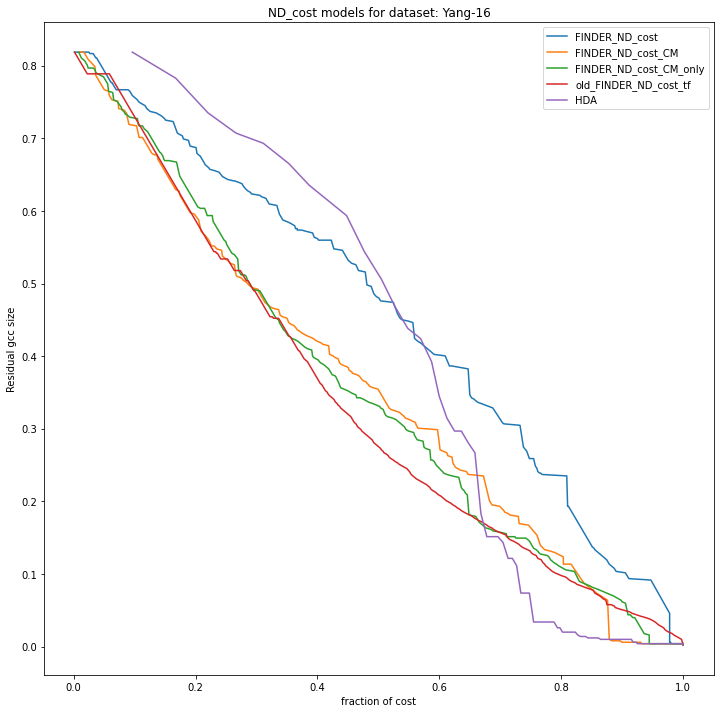

In [28]:
plot_cost_graphs("Yang-16",cost_model_settings)

  1%|█▏                                                                              | 62/4165 [00:00<00:06, 610.80it/s]

Evaluating FINDER model
number of nodes:4165
number of edges:13087
number of solution nodes:4165


  1%|█▏                                                                              | 62/4165 [00:00<00:06, 613.45it/s]

Evaluating FINDER model
number of nodes:4165
number of edges:13087
number of solution nodes:4165


  1%|█▏                                                                              | 62/4165 [00:00<00:06, 612.62it/s]

Evaluating FINDER model
number of nodes:4165
number of edges:13087
number of solution nodes:4165


  1%|█▏                                                                              | 62/4165 [00:00<00:06, 610.83it/s]

Evaluating FINDER model
number of nodes:4165
number of edges:13087
number of solution nodes:4165


100%|█████████████████████████████████████████████████████████████████████████████| 4165/4165 [00:03<00:00, 1227.81it/s]


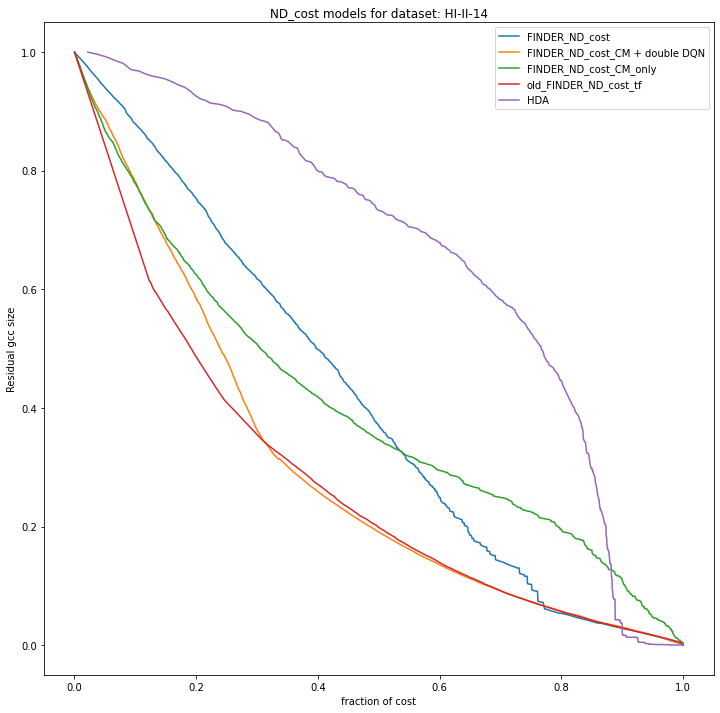

100%|███████████████████████████████████████████████████████████████████████████████| 502/502 [00:00<00:00, 9375.83it/s]

Evaluating FINDER model
number of nodes:502
number of edges:717
number of solution nodes:502
Evaluating FINDER model
number of nodes:502
number of edges:717
number of solution nodes:502
Evaluating FINDER model
number of nodes:502
number of edges:717
number of solution nodes:502
Evaluating FINDER model
number of nodes:502
number of edges:717
number of solution nodes:502



100%|███████████████████████████████████████████████████████████████████████████████| 502/502 [00:00<00:00, 9737.86it/s]


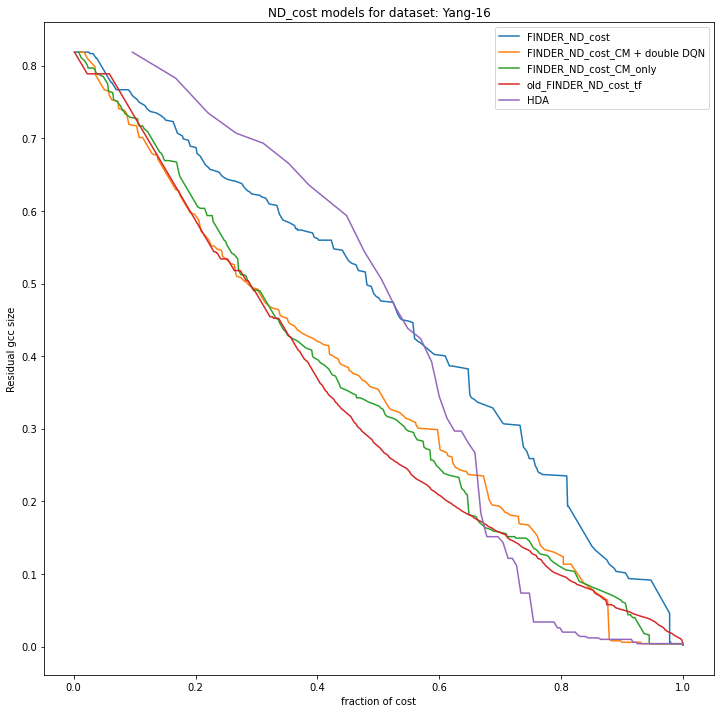

 23%|██████████████████                                                            | 262/1132 [00:00<00:00, 2614.74it/s]

Evaluating FINDER model
number of nodes:1132
number of edges:1126
number of solution nodes:1132


 23%|█████████████████▉                                                            | 260/1132 [00:00<00:00, 2597.47it/s]

Evaluating FINDER model
number of nodes:1132
number of edges:1126
number of solution nodes:1132


 23%|█████████████████▉                                                            | 260/1132 [00:00<00:00, 2599.22it/s]

Evaluating FINDER model
number of nodes:1132
number of edges:1126
number of solution nodes:1132


 23%|██████████████████                                                            | 262/1132 [00:00<00:00, 2616.03it/s]

Evaluating FINDER model
number of nodes:1132
number of edges:1126
number of solution nodes:1132


100%|█████████████████████████████████████████████████████████████████████████████| 1132/1132 [00:00<00:00, 4454.37it/s]


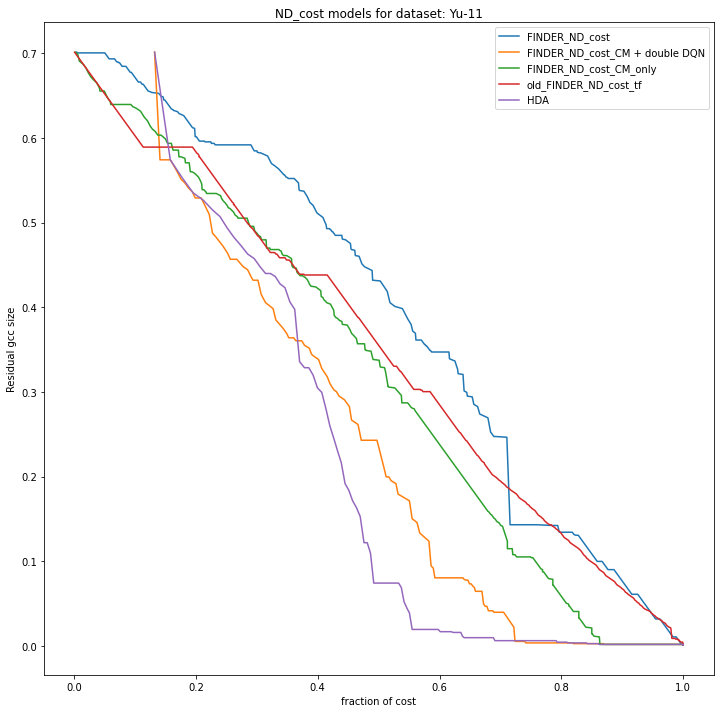

100%|██████████████████████████████████████████████████████████████████████████████| 195/195 [00:00<00:00, 20913.07it/s]

Evaluating FINDER model
number of nodes:195
number of edges:187
number of solution nodes:195
Evaluating FINDER model
number of nodes:195
number of edges:187
number of solution nodes:195
Evaluating FINDER model
number of nodes:195
number of edges:187
number of solution nodes:195
Evaluating FINDER model
number of nodes:195
number of edges:187
number of solution nodes:195


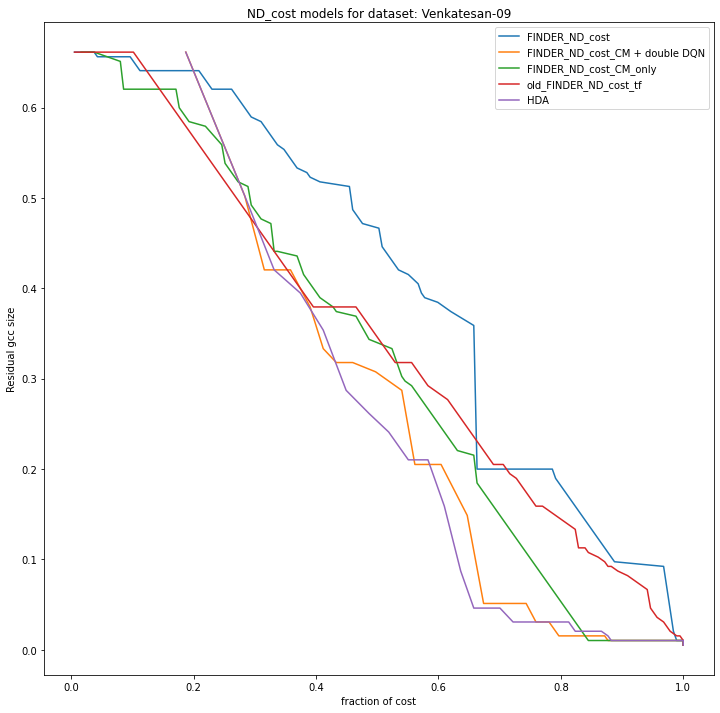

 12%|█████████▋                                                                    | 186/1504 [00:00<00:00, 1858.36it/s]

Evaluating FINDER model
number of nodes:1504
number of edges:2565
number of solution nodes:1504


 13%|█████████▉                                                                    | 191/1504 [00:00<00:00, 1904.95it/s]

Evaluating FINDER model
number of nodes:1504
number of edges:2565
number of solution nodes:1504


 12%|█████████▊                                                                    | 188/1504 [00:00<00:00, 1874.61it/s]

Evaluating FINDER model
number of nodes:1504
number of edges:2565
number of solution nodes:1504


 12%|█████████▋                                                                    | 187/1504 [00:00<00:00, 1866.70it/s]

Evaluating FINDER model
number of nodes:1504
number of edges:2565
number of solution nodes:1504


100%|█████████████████████████████████████████████████████████████████████████████| 1504/1504 [00:00<00:00, 3446.88it/s]


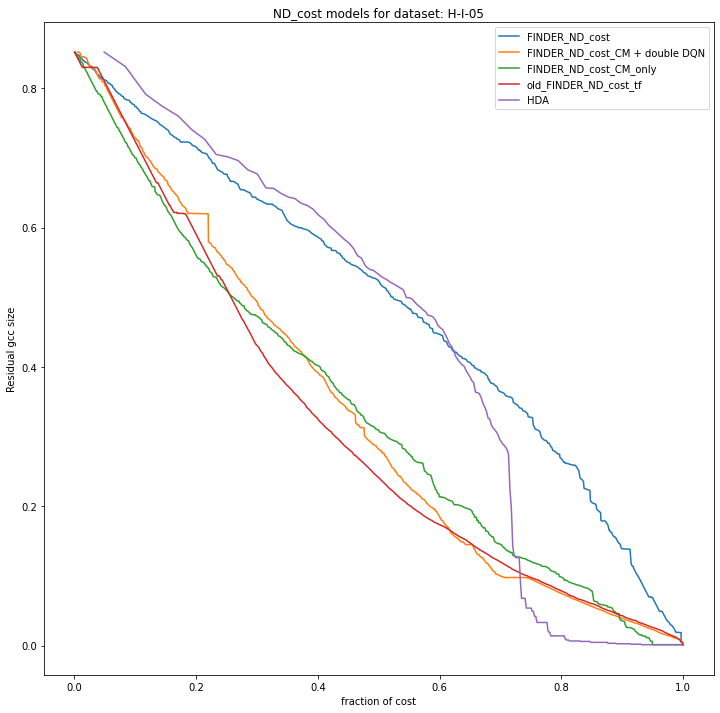

In [36]:
for dataset in datasets:
    plot_cost_graphs(dataset,cost_model_settings)